# Sales Forecasting with Facebook Prophet

<i>Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.</i>
<br><br>
In this notebook, we will test the Facebook Prophet tool on data regarding sales in differemt shops. We will use two dataframes, one containing data related to the shops, one containing sales by shop and day by day. We will do some data preprocessing and analysis, first by singular dataset, then merging the two of them. And then we will apply the Facebook tool and check its results.

In [1]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime

## Import Sales Training Data

In [2]:
sales_train_df = pd.read_csv('train.csv')
sales_train_df.head()

# Note that sales is the target variable (that's what we are trying to predict) 
# Id: transaction ID (combination of Store and date) 
# Store: unique store Id
# Sales: sales/day, this is the target variable 
# Customers: number of customers on a given day
# Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
# Promo: describes if store is running a promo on that day or not
# StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
# SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools

#- Data Source: https://www.kaggle.com/c/rossmann-store-sales/data

/Users/maurizioscibilia/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
sales_train_df.tail()

# there are 1115 unique stores 

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [4]:
sales_train_df.info()

# 9 columns in total 
# 8 features, each contains 1017209 data points
# 1 target variable (sales)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [5]:
sales_train_df.describe()

# Average sales amount per day = 5773 Euros, minimum sales per day = 0, maximum sales per day = 41551 
# Average number of customers = 633, minimum number of customers = 0, maximum number of customers = 7388

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


## Import Store Information Data

In [6]:
store_info_df = pd.read_csv('store.csv')
store_info_df.head()

# StoreType: categorical variable to indicate type of store (a, b, c, d)
# Assortment: describes an assortment level: a = basic, b = extra, c = extended
# CompetitionDistance (meters): distance to closest competitor store
# CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open
# Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 
#    1 = store is participating)
# Promo2Since [Year/Week]: date when the store started participating in Promo2
# PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is 
#    started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any 
#    given year for that store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
store_info_df.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [8]:
store_info_df.info()

# this dataframe includes information about the 1115 stores that are part of our study
# so this is the number of rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [9]:
store_info_df.describe()

# on average, the competition distance is 5404 meters away (5.4 kms)

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


## Explore Dataset

### Training data

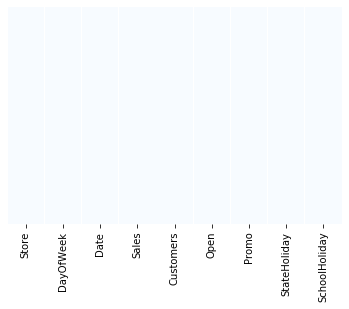

In [10]:
# luckily we don't have missing data in the train dataset

sns.heatmap(sales_train_df.isnull(), yticklabels=False, cbar=False, cmap='Blues');

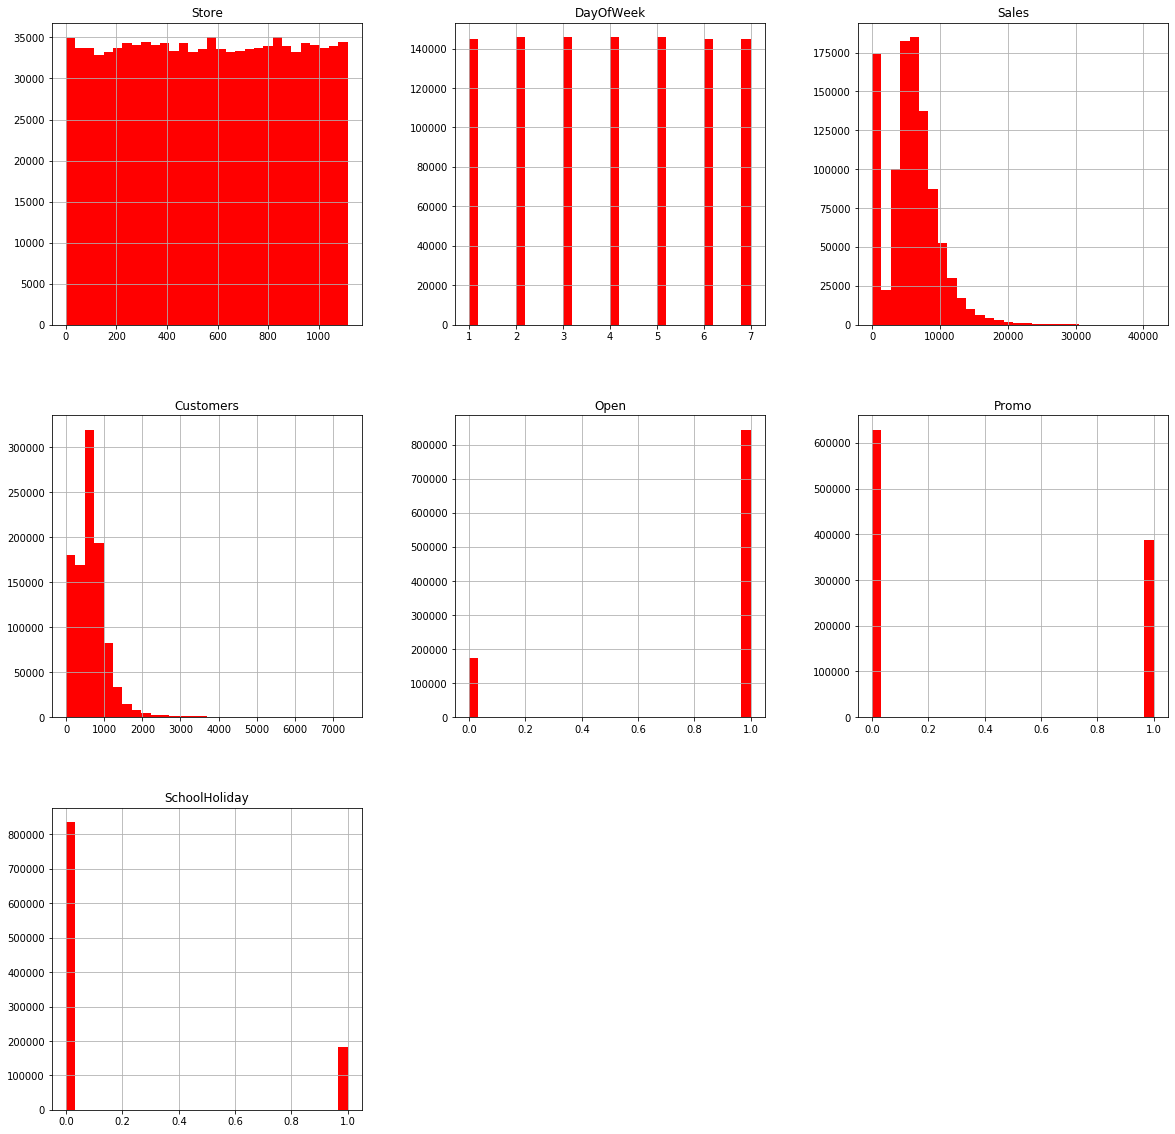

In [11]:
# plot the histogram of our data

sales_train_df.hist(bins = 30, figsize = (20,20), color = 'r');

# Data is equally distributed among all stores (no bias)
# Data is also equally distibuted across various Days of the week 
# Average sales around 5000-6000 Euros
# Average 600 customers per day, maximum is 4500 (note that we can't see the outlier at 7388!)
# Stores are open ~80% of the time
# Promo #1 was running ~40% of the time 
# School holidays are around ~18% of the time

In [12]:
# What's the maximum number of customers?

sales_train_df['Customers'].max()

7388

In [13]:
# Let's see how many stores are open and closed! 

open_train_df          = sales_train_df[sales_train_df['Open'] == 1]
closed_train_df        = sales_train_df[sales_train_df['Open'] == 0]

In [14]:
# Count the number of stores that are open and closed

print("Number of open stores =", len(open_train_df))
print("Number of closed stores =", len(closed_train_df))
print("Total =", len(sales_train_df))

Number of open stores = 844392
Number of closed stores = 172817
Total = 1017209


In [15]:
# only keep open stores and remove closed stores

sales_train_df = open_train_df
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [16]:
# Let's drop the open column since it has no meaning now

sales_train_df.drop(['Open'], axis=1, inplace=True)
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


In [17]:
sales_train_df.describe()

# Average sales = 6955 Euros,   average number of customers = 762   (went up)

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


### Store Data

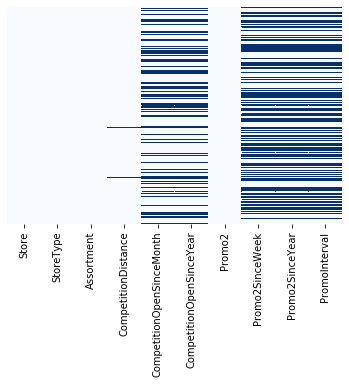

In [18]:
# we have missing data in the store dataset

sns.heatmap(store_info_df.isnull(), yticklabels=False, cbar=False, cmap='Blues');

In [19]:
# let's see how many

store_info_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [20]:
# Let's take a look at the missing values in the 'CompetitionDistance'
# Only 3 rows are missing 

store_info_df[store_info_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [21]:
# Let's take a look at the missing values in the 'CompetitionOpenSinceMonth'
# many rows are missing = 354 (almost one third of the 1115 stores)

store_info_df[store_info_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [22]:
# When 'promo2' is zero, 'promo2SinceWeek', 'Promo2SinceYear', and 'PromoInterval' are set to zero

store_info_df[store_info_df['Promo2']==0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


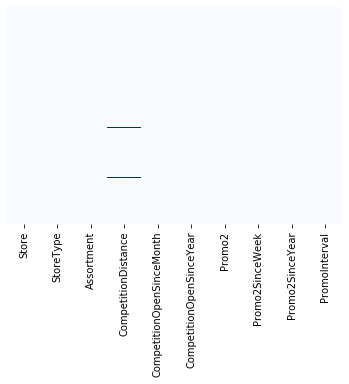

In [23]:
# We can set all the missing values except the 'CompetitionDistance' ones to 0

str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 
            'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']
for str in str_cols:
    store_info_df [str].fillna(0, inplace = True)
sns.heatmap(store_info_df.isnull(), yticklabels=False, cbar=False, cmap='Blues');

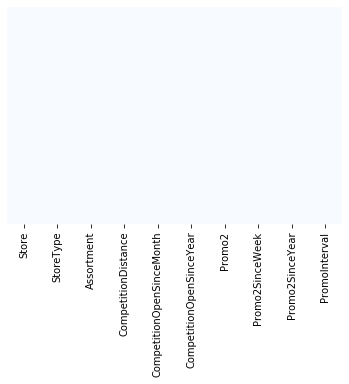

In [24]:
# perfect, now we just have the 3 values in the 'CompetitionDistance' column
# let's fill these with the average values of the 'CompetitionDistance' column

store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(), inplace=True)
sns.heatmap(store_info_df.isnull(), yticklabels=False, cbar=False, cmap='Blues');

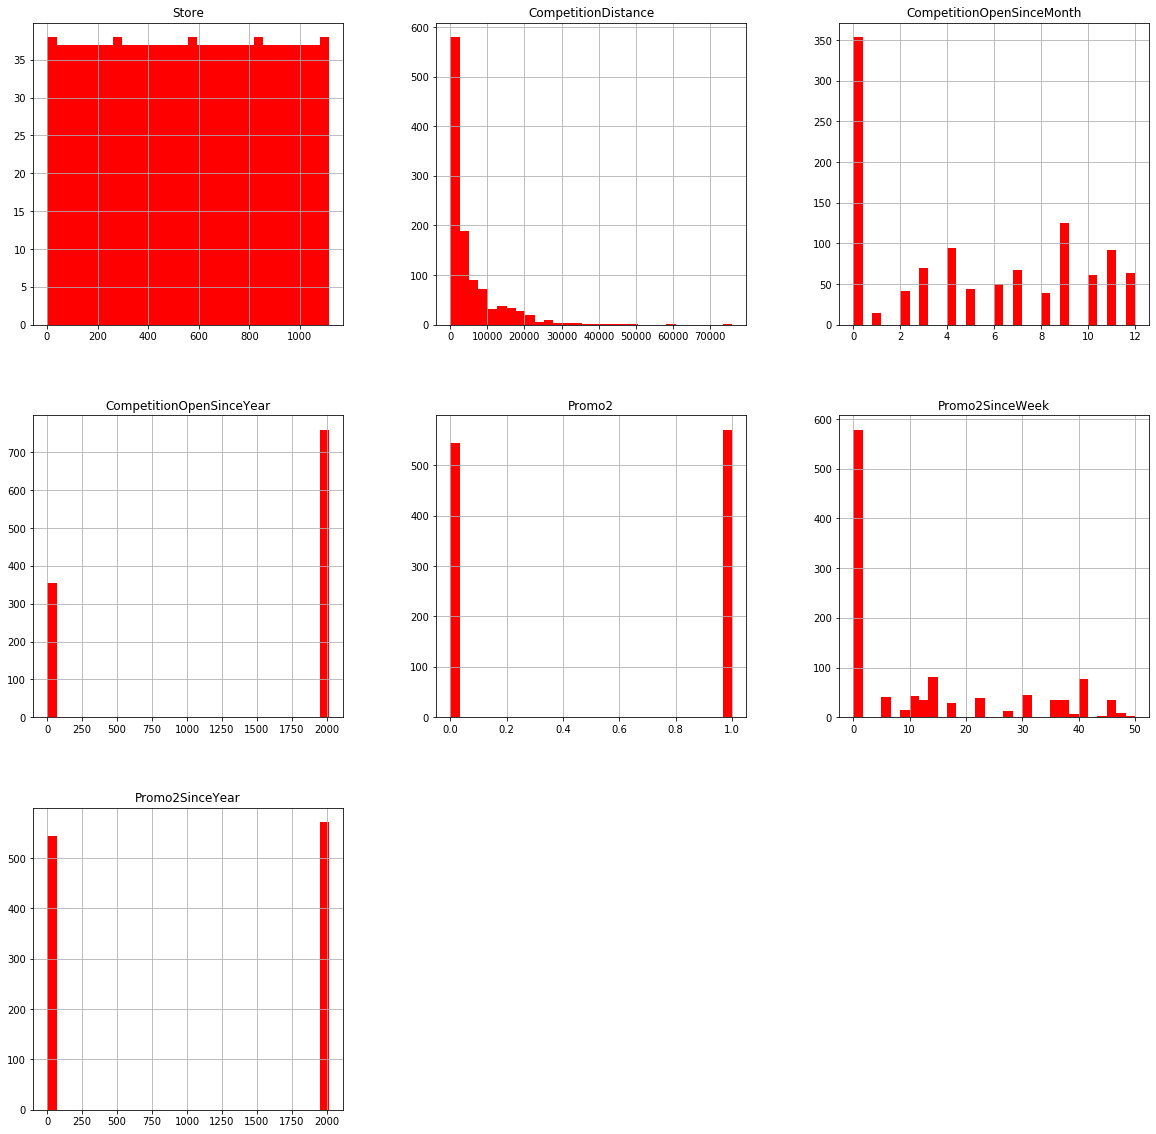

In [25]:
# great, our removing missing values job seems over
# we can check this dataframe histograms now

store_info_df.hist(bins = 30, figsize = (20,20), color = 'r');

# half of stores are involved in promo 2
# half of the stores have their competition at a distance of 0-3000m (3 kms away)

### Merged Data

In [26]:
# Let's merge both data frames together based on 'Store'

merged_data_df = pd.merge(sales_train_df, store_info_df, how='inner', on='Store')
merged_data_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [27]:
# Let's check our correlations with the sales

correlations_sales = merged_data_df.corr()['Sales'].sort_values()
correlations_sales

# Customers is strongly correlated
# Promo shows some correlation as well

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

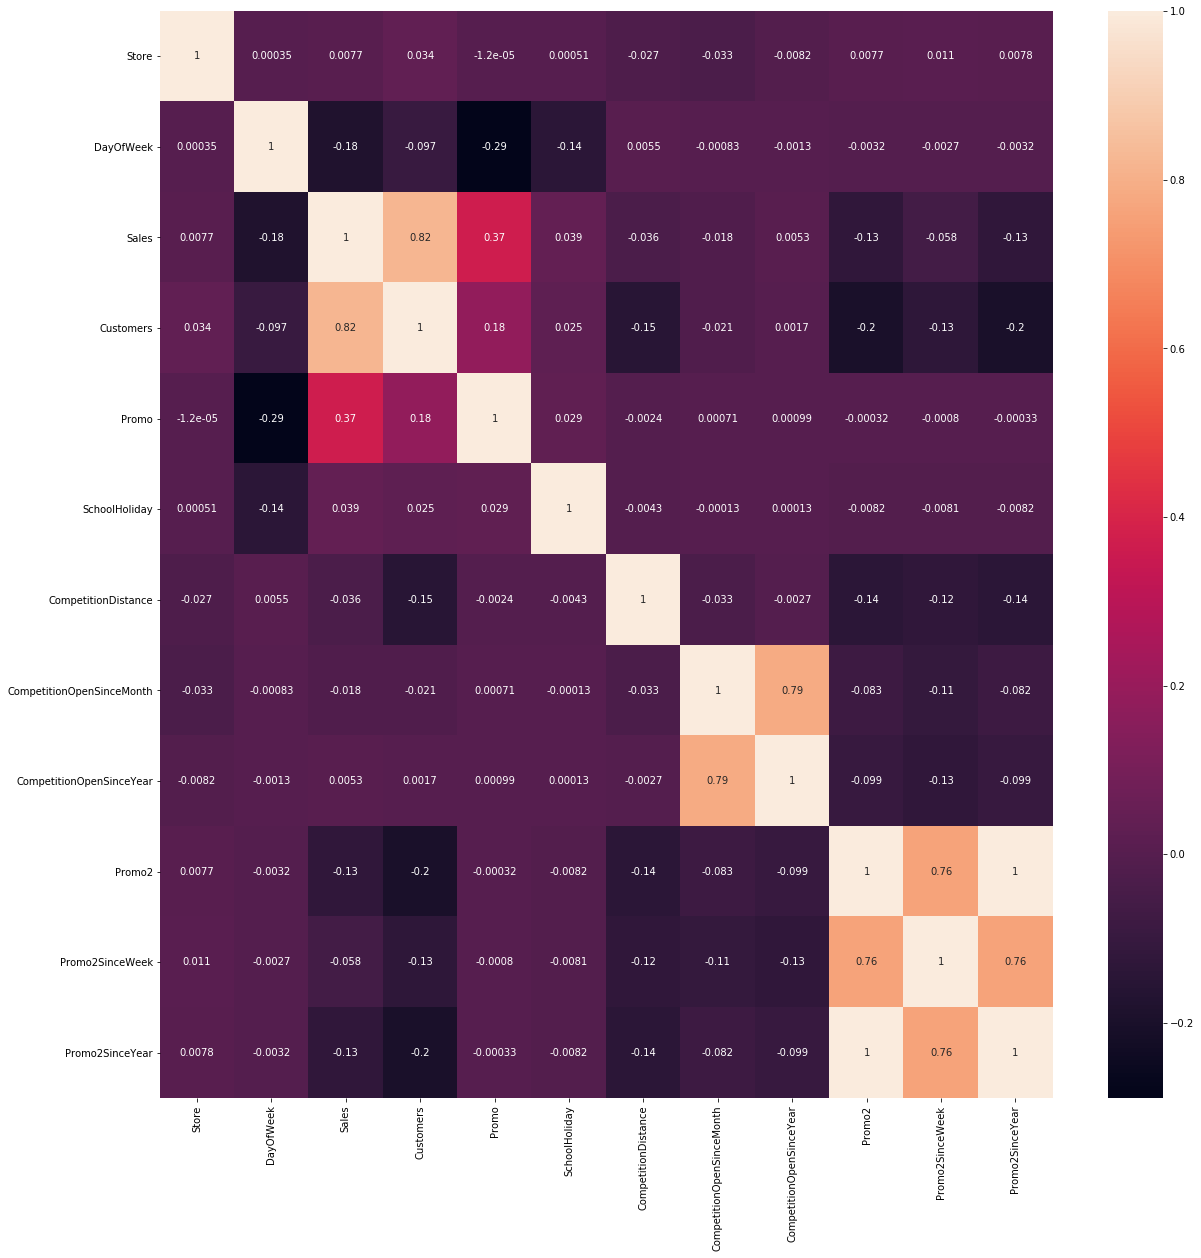

In [28]:
# Now we check all the correlations in just one diagragm

correlations = merged_data_df.corr()
_, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True, ax=ax);

# Customers/Promo and Sales are positevely correlated as we knew

In [29]:
# Let's extract year, month and day from the date and put it into separate columns

merged_data_df['Year'] = pd.DatetimeIndex(merged_data_df['Date']).year
merged_data_df['Month'] = pd.DatetimeIndex(merged_data_df['Date']).month
merged_data_df['Day'] = pd.DatetimeIndex(merged_data_df['Date']).day
merged_data_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,7
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,5
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,4
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,3


In [30]:
pd.to_datetime(merged_data_df['Date'])

0        2015-07-31
1        2015-07-30
2        2015-07-29
3        2015-07-28
4        2015-07-27
            ...    
844387   2013-01-07
844388   2013-01-05
844389   2013-01-04
844390   2013-01-03
844391   2013-01-02
Name: Date, Length: 844392, dtype: datetime64[ns]

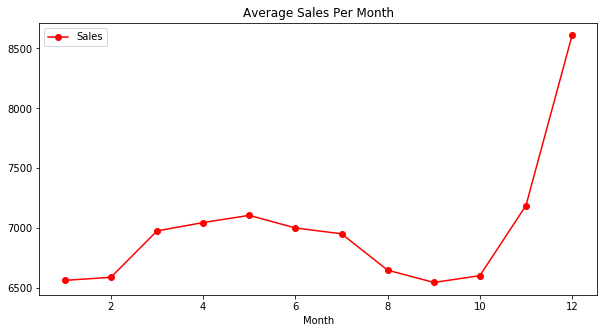

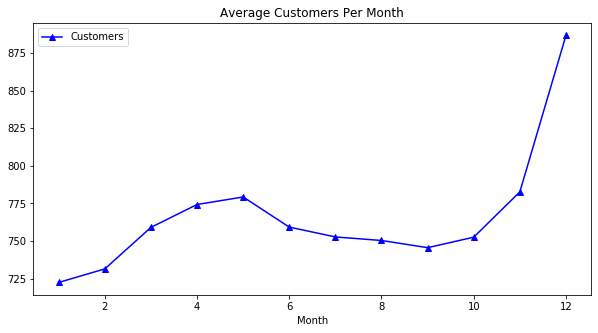

In [31]:
# Let's take a look at the average sales and number of customers per month 

axis = merged_data_df.groupby('Month')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r');
axis.set_title('Average Sales Per Month')
axis = merged_data_df.groupby('Month')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Customers Per Month');

# It looks like sales and number of customers peak around christmas timeframe

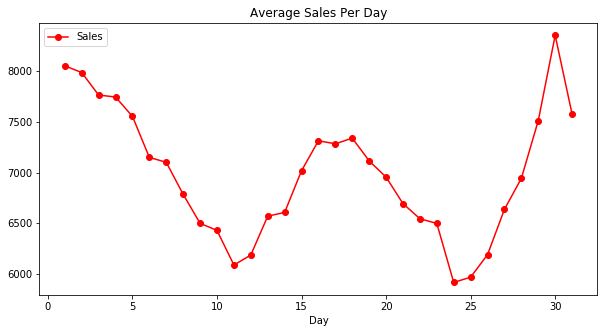

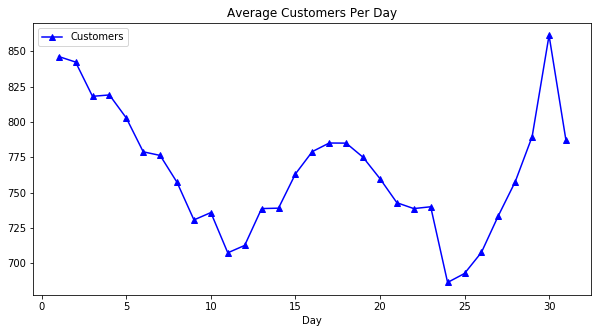

In [32]:
# Let's take a look at the sales and customers per day of the month instead

axis = merged_data_df.groupby('Day')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r');
axis.set_title('Average Sales Per Day')
axis = merged_data_df.groupby('Day')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Customers Per Day');

# Minimum number of customers are generally around the 24th of the month 
# Most customers and sales are around 30th and 1st of the month
# Is salary paid still on the 27th?

Text(0.5, 1.0, 'Average Customers Per Day of the Week')

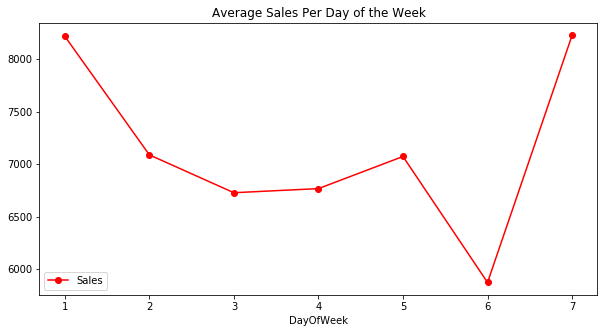

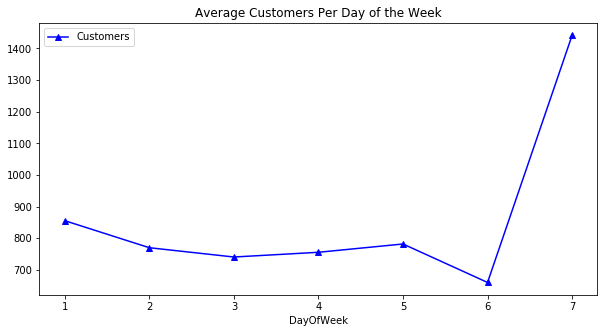

In [33]:
# Let's do the same for the day of the week  (note that 7 = Sunday)

axis = merged_data_df.groupby('DayOfWeek')[['Sales']].mean().plot(figsize = (10,5), 
                                                                  marker = 'o', 
                                                                  color = 'r');
axis.set_title('Average Sales Per Day of the Week')
axis = merged_data_df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10,5), 
                                                                      marker = '^', 
                                                                      color = 'b');
axis.set_title('Average Customers Per Day of the Week')

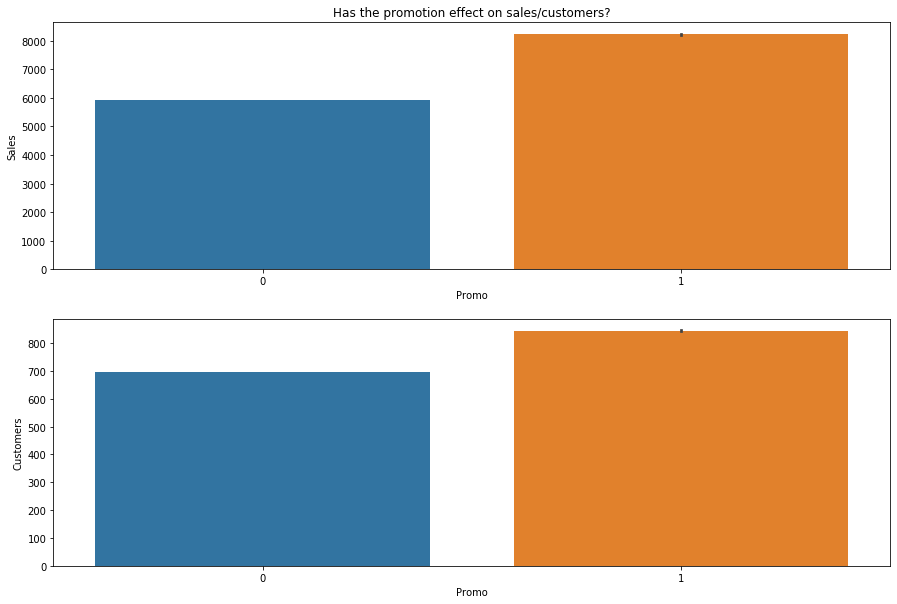

In [34]:
# Has the promotion any effect on sales or number of customers

plt.figure(figsize=[15,10])
plt.subplot(211)
sns.barplot(x = 'Promo', y = 'Sales', data = merged_data_df);
plt.title('Has the promotion effect on sales/customers?')
plt.subplot(212)
sns.barplot(x = 'Promo', y = 'Customers', data = merged_data_df);

# It sems that the promotion, as expected, increases sales/customers

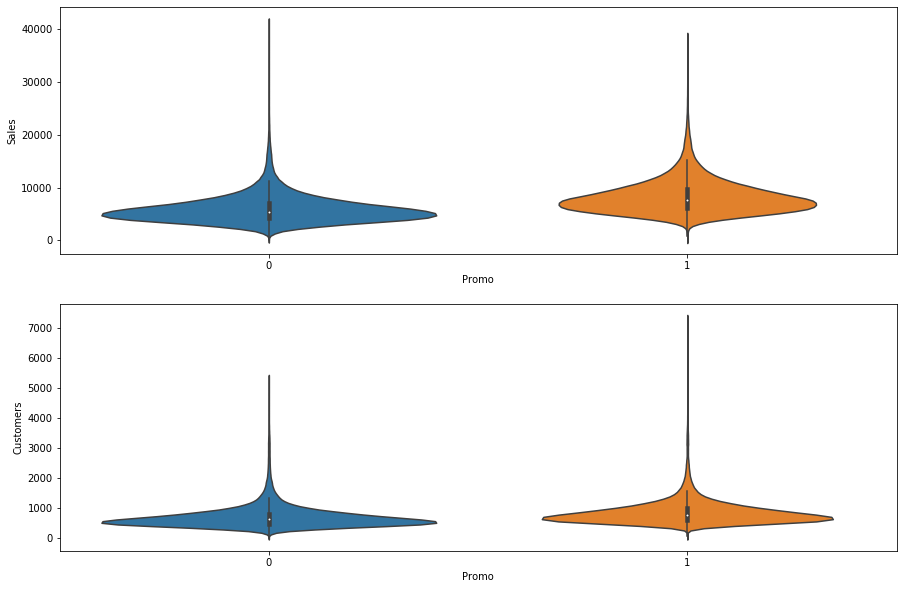

In [35]:
# let's check with another kind of charts: violinplots

plt.figure(figsize=[15,10])
plt.subplot(211)
sns.violinplot(x = 'Promo', y = 'Sales', data = merged_data_df);
plt.subplot(212)
sns.violinplot(x = 'Promo', y = 'Customers', data = merged_data_df);

## Facebook Prophet

Prophet is open source software released by Facebook’s Core Data Science team.
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 
Prophet works best with time series that have strong seasonal effects and several seasons of historical data. 

Prophet implements an additive regression model with four elements:
<ul>
    <li> a piecewise linear,</li>
    <li> a yearly seasonal component modeled using Fourier series,</li>
    <li> a weekly seasonal component,</li> 
    <li> a holiday list that can be manually provided.</li>
</ul>

## Train the Model

In [36]:
# importing Prophet

from fbprophet import Prophet

In [37]:
# let's add holidays to our function

def sales_prediction(Store_ID, sales_df, holidays, periods):
  # Function that takes in the storeID and returns two date/sales columns in Prophet format
  # Format data to fit prophet 

  sales_df = sales_df[ sales_df['Store'] == Store_ID ]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')
  
  model    = Prophet(holidays = holidays, daily_seasonality=True)
  model.fit(sales_df)
  future   = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)
  figure   = model.plot(forecast, xlabel='Date', ylabel='Sales')
  figure2  = model.plot_components(forecast)

In [38]:
# Get all dates pertaining to school holidays

school_holidays = merged_data_df[merged_data_df['SchoolHoliday'] == 1].loc[:, 'Date'].values
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                                'holiday': 'school_holiday'})
school_holidays

,ds,holiday
0,2015-07-31,school_holiday
1,2015-07-30,school_holiday
2,2015-07-29,school_holiday
3,2015-07-28,school_holiday
4,2015-07-27,school_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


In [39]:
# Get all dates pertaining to state holidays 

state_holidays = merged_data_df [(merged_data_df['StateHoliday'] == 'a') | (merged_data_df['StateHoliday'] == 'b') | (merged_data_df['StateHoliday'] == 'c')  ].loc[:, 'Date'].values
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                               'holiday': 'state_holiday'})
state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
905,2013-04-01,state_holiday
906,2013-08-15,state_holiday
907,2015-06-04,state_holiday
908,2014-06-19,state_holiday


In [40]:
# concatenate both school and state holidays 

school_state_holidays = pd.concat((state_holidays, school_holidays))

In [41]:
school_state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


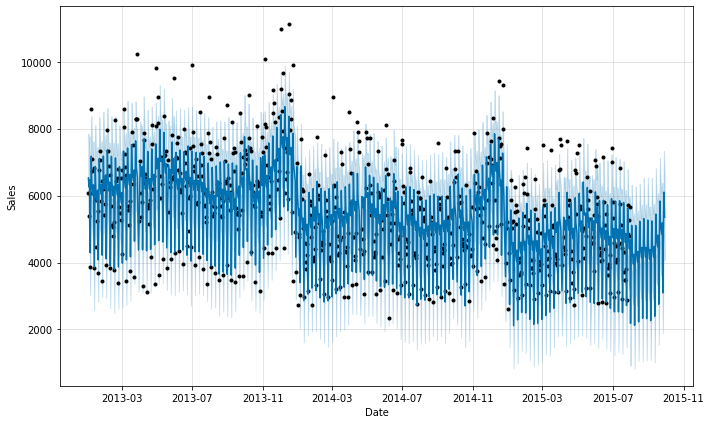

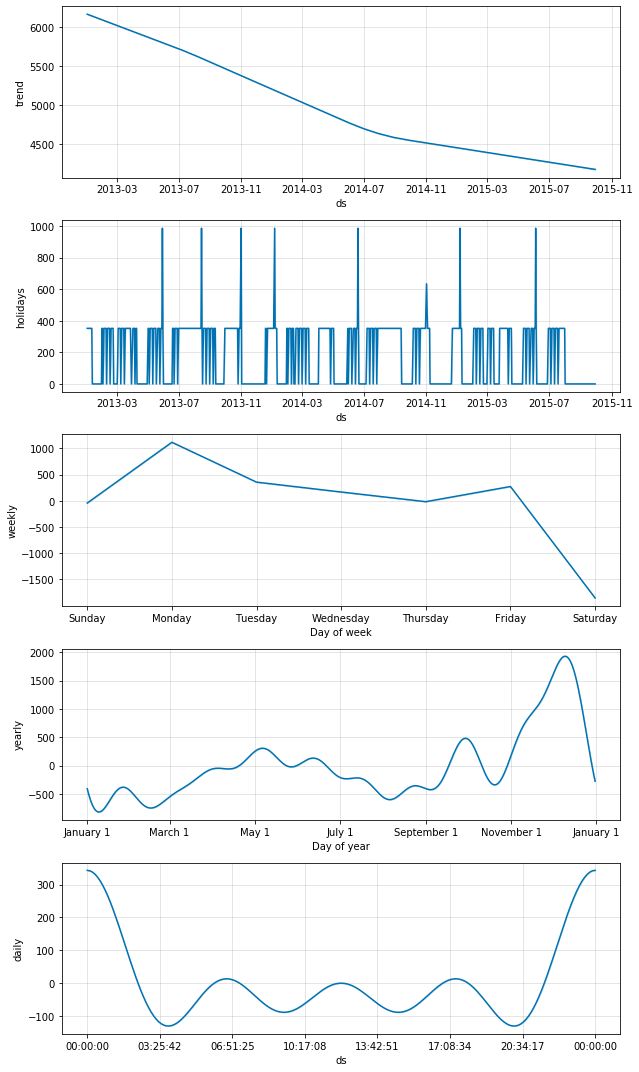

In [42]:
# Let's make predictions using holidays for a specific store

sales_prediction(6, merged_data_df, school_state_holidays, 60)

## Conclusions

In this notebook, we have seen an interesting approach for <b<data forecasting</b>. I had already seen and used <em>LSTMs</em>, or <em>xgboost</em>. Facebook Prophet is definitely another tool we can use for these purposes. Many thanks to Dr. Ryan Ahmed Ph.D. MBA for showing it inside his course on the Udemy platform.